# Data Processing
Goal: Extract relevant information from neo4j to create final dataset for ML modelling

The model will have two input data sources:

The shared-features array will be a 3-D matrix of (n,n,4) <br>
n = no. movies <br>
3 = number of shared features being analysed (genres, director, actors, pairwise-scoring)<br>

The movie-level dataset will contain the following vars:
- Movie Id
- 

This format is used for both compact storage, and ease of use in GNNs and analysis

As these datafiles will be large, Apache Spark will be used to handle the heavy workload

In [1]:
print("Importing packages...")
from py2neo import Graph, Node, Relationship
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, DoubleType
print("Completed!")

Importing packages...
Completed!


#### Initialising PySpark

In [2]:
# Create Spark session
spark = SparkSession.builder \
    .appName("MovieRecommendation") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

print("Spark session created!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 10:57:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created!


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 56869)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/homebrew/Cellar/python@3.10/3.10.14_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/Users/scottpitcher/Desktop/python/Github/mov

### Movie-level data

In [3]:
node_df = pd.read_csv("data/full_data_nodes.csv")
node_df = node_df.drop(node_df.columns[0], axis =1) # Drop unnamed col
movie_ids = pd.read_csv("data/full_data_nodes.csv")["id"].tolist()

movie_df = spark.createDataFrame(node_df) 
movie_df.show()

+-------+--------------------+--------------------+----------+------------+------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+------+
|     id|               title|            overview|popularity|release_date|vote_average|vote_count|           genre_ids|              genres|              actors|            director|    log_popularity|popularity_bin|degree|
+-------+--------------------+--------------------+----------+------------+------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+------+
| 912649|Venom: The Last D...|Eddie and Venom a...|  3197.278|  2024-10-22|         6.5|       763|       [878, 28, 12]|['Science Fiction...|['Tom Hardy', 'Ch...|        Kelly Marcel| 8.070367818946595|           Top|    11|
|1034541|         Terrifier 3|Five years after ...|  2204.248|  2024-10-09|         6.9|      1015| 

### Shared feature data

In [4]:
# Load the shared features matrix
shared_features = np.load("data/shared_matrix.npy").astype(float)

# Load the movie DataFrame to get actual IDs
movie_ids = movie_df.select("id").orderBy("id").rdd.flatMap(lambda x: x).collect()  # Collect all movie IDs in order

# Ensure matrix dimensions match the number of movie IDs
assert len(movie_ids) == shared_features.shape[0], "Number of movie IDs and shared features matrix size mismatch."

# Map indices to actual movie IDs
pairwise_list = []
n_movies = len(movie_ids)

for i in range(n_movies):
    for j in range(n_movies):
        pairwise_list.append((
            movie_ids[i],  # Actual InputMovie_id
            movie_ids[j],  # Actual CandidateMovie_id
            float(shared_features[i, j, 0]),  # shared_genres
            float(shared_features[i, j, 1]),  # shared_actors
            float(shared_features[i, j, 2])   # shared_directors
        ))

# Define the schema
schema = StructType([
    StructField("InputMovie_id", IntegerType(), True),
    StructField("CandidateMovie_id", IntegerType(), True),
    StructField("shared_genres", DoubleType(), True),
    StructField("shared_actors", DoubleType(), True),
    StructField("shared_directors", DoubleType(), True)
])

# Create the Spark DataFrame
pairwise_df = spark.createDataFrame(pairwise_list, schema=schema)

# Remove the list for memory
del pairwise_list
gc.collect

# Show the DataFrame
pairwise_df.show()

OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=17994Kb max_used=18000Kb free=113077Kb
 bounds [0x000000010698c000, 0x0000000107b3c000, 0x000000010e98c000]
 total_blobs=7243 nmethods=6359 adapters=798
 compilation: disabled (not enough contiguous free space left)


24/11/26 10:58:14 WARN TaskSetManager: Stage 5 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----------------+-------------+-------------+----------------+
|InputMovie_id|CandidateMovie_id|shared_genres|shared_actors|shared_directors|
+-------------+-----------------+-------------+-------------+----------------+
|           11|               11|          0.0|          0.0|             0.0|
|           11|               12|          0.0|          0.0|             0.0|
|           11|               13|          1.0|          0.0|             0.0|
|           11|               18|          1.0|          0.0|             0.0|
|           11|               24|          2.0|          0.0|             0.0|
|           11|               25|          2.0|          0.0|             0.0|
|           11|               28|          1.0|          0.0|             0.0|
|           11|               35|          1.0|          0.0|             0.0|
|           11|               35|          2.0|          0.0|             0.0|
|           11|               38|          1.0|     

24/11/26 10:58:18 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 5 (TID 18): Attempting to kill Python Worker


You may notice self-pairs (row 1: 11,11) have a shared feature value of 0. While this may seem strange at first, this is to prevent that movie from being recommended if it is an input value in the model!

### Merging the data

First, we need to split the movie-level data into two distinct dataframes:
1. input movie data (movie_1)
2. candidate movie data (movie_2)

In [14]:
# Rename columns in movie_df for clarity during the join
InputMovie_df = movie_df.withColumnRenamed("id", "InputMovie_id") \
                    .withColumnRenamed("title", "InputMovie_title") \
                    .withColumnRenamed("log_popularity", "InputMovie_log_popularity") \
                    .withColumnRenamed("popularity", "InputMovie_popularity") \
                    .withColumnRenamed("vote_average", "InputMovie_vote_average") \
                    .withColumnRenamed("vote_count", "InputMovie_vote_count").repartition(200)

CandidateMovie_df = movie_df.withColumnRenamed("id", "CandidateMovie_id") \
                    .withColumnRenamed("title", "CandidateMovie_title") \
                    .withColumnRenamed("log_popularity", "CandidateMovie_log_popularity") \
                    .withColumnRenamed("vote_average", "CandidateMovie_vote_average") \
                    .withColumnRenamed("vote_count", "CandidateMovie_vote_count") \
                    .withColumnRenamed("degree", "CandidateMovie_degree").repartition(200)

# Join pairwise_df with InputMovie_df on InputMovie_id
merged_df = pairwise_df.join(InputMovie_df, on="InputMovie_id", how="inner").repartition(200)

# Join the result with CandidateMovie_df on CandidateMovie_id
merged_df = merged_df.join(CandidateMovie_df, on="CandidateMovie_id", how="inner")

# Select the columns you need (can adjust based on requirements)
merged_df = merged_df.select(
    "InputMovie_id", "InputMovie_title", "InputMovie_popularity", "InputMovie_vote_average","InputMovie_vote_count",
    "CandidateMovie_id", "CandidateMovie_title", "CandidateMovie_popularity", "CandidateMovie_vote_average", "CandidateMovie_vote_count",
    "shared_genres", "shared_actors", "shared_directors"
).repartition(200)

# Show the merged DataFrame
merged_df.show()


24/11/26 11:22:29 WARN TaskSetManager: Stage 132 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.


+-------------+--------------------+---------------------+-----------------------+---------------------+-----------------+--------------------+-------------------------+---------------------------+-------------------------+-------------+-------------+----------------+
|InputMovie_id|    InputMovie_title|InputMovie_popularity|InputMovie_vote_average|InputMovie_vote_count|CandidateMovie_id|CandidateMovie_title|CandidateMovie_popularity|CandidateMovie_vote_average|CandidateMovie_vote_count|shared_genres|shared_actors|shared_directors|
+-------------+--------------------+---------------------+-----------------------+---------------------+-----------------+--------------------+-------------------------+---------------------------+-------------------------+-------------+-------------+----------------+
|          605|The Matrix Revolu...|                61.95|                  6.728|                 9840|           976734|        Canary Black|                  520.741|                      6.

### Creating the label var (match_score) [0-1]

#### Normalizing feature vars

In [8]:
print(merged_df.columns)


['InputMovie_id', 'InputMovie_title', 'InputMovie_popularity', 'InputMovie_vote_average', 'CandidateMovie_id', 'CandidateMovie_title', 'CandidateMovie_popularity', 'CandidateMovie_vote_average', 'shared_genres', 'shared_actors', 'shared_directors', 'normalized_CandidateMovie_popularity']


In [16]:
from pyspark.sql.functions import min, max, col

# List of all vars to normalise
variables_to_normalize = [
    "CandidateMovie_popularity",
    "CandidateMovie_vote_count",
    "shared_genres",
    "shared_actors",
    "shared_directors"
]

# Loop through each variable and normalise it (min-max)
for variable in variables_to_normalize:

    min_val, max_val = merged_df.select(min(col(variable)), max(col(variable))).first()
    
    # Normalize the variable and add as a new column
    normalized_column = f"normalized_{variable}"
    merged_df = merged_df.withColumn(
        normalized_column,
        (col(variable) - min_val) / (max_val - min_val)
    )

# Show the DataFrame with normalized columns
merged_df.show()


24/11/26 11:39:17 WARN TaskSetManager: Stage 224 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.
24/11/26 11:39:25 WARN TaskSetManager: Stage 240 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.
24/11/26 11:39:32 WARN TaskSetManager: Stage 256 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.
24/11/26 11:39:44 WARN TaskSetManager: Stage 269 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.
24/11/26 11:39:53 WARN TaskSetManager: Stage 282 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.
24/11/26 11:40:00 WARN TaskSetManager: Stage 295 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.


+-------------+--------------------+---------------------+-----------------------+---------------------+-----------------+--------------------+-------------------------+---------------------------+-------------------------+-------------+-------------+----------------+------------------------------------+------------------------------------+------------------------+------------------------+---------------------------+
|InputMovie_id|    InputMovie_title|InputMovie_popularity|InputMovie_vote_average|InputMovie_vote_count|CandidateMovie_id|CandidateMovie_title|CandidateMovie_popularity|CandidateMovie_vote_average|CandidateMovie_vote_count|shared_genres|shared_actors|shared_directors|normalized_CandidateMovie_popularity|normalized_CandidateMovie_vote_count|normalized_shared_genres|normalized_shared_actors|normalized_shared_directors|
+-------------+--------------------+---------------------+-----------------------+---------------------+-----------------+--------------------+---------------

24/11/26 11:14:48 WARN TaskSetManager: Stage 111 contains a task of very large size (18106 KiB). The maximum recommended task size is 1000 KiB.
Exception in thread "serve-DataFrame"                                           java.lang.OutOfMemoryError: GC overhead limit exceeded
	at java.lang.Integer.valueOf(Integer.java:832)
	at net.razorvine.pickle.Pickler.lookupMemo(Pickler.java:228)
	at net.razorvine.pickle.Pickler.save(Pickler.java:185)
	at net.razorvine.pickle.Pickler.put_arrayOfObjects(Pickler.java:585)
	at net.razorvine.pickle.Pickler.dispatch(Pickler.java:254)
	at net.razorvine.pickle.Pickler.save(Pickler.java:185)
	at net.razorvine.pickle.Pickler.dump(Pickler.java:155)
	at net.razorvine.pickle.Pickler.dumps(Pickler.java:140)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:92)
	at org.apache.spark.api.python.SerDeUtil$AutoBatchedPickler.next(SerDeUtil.scala:80)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Itera

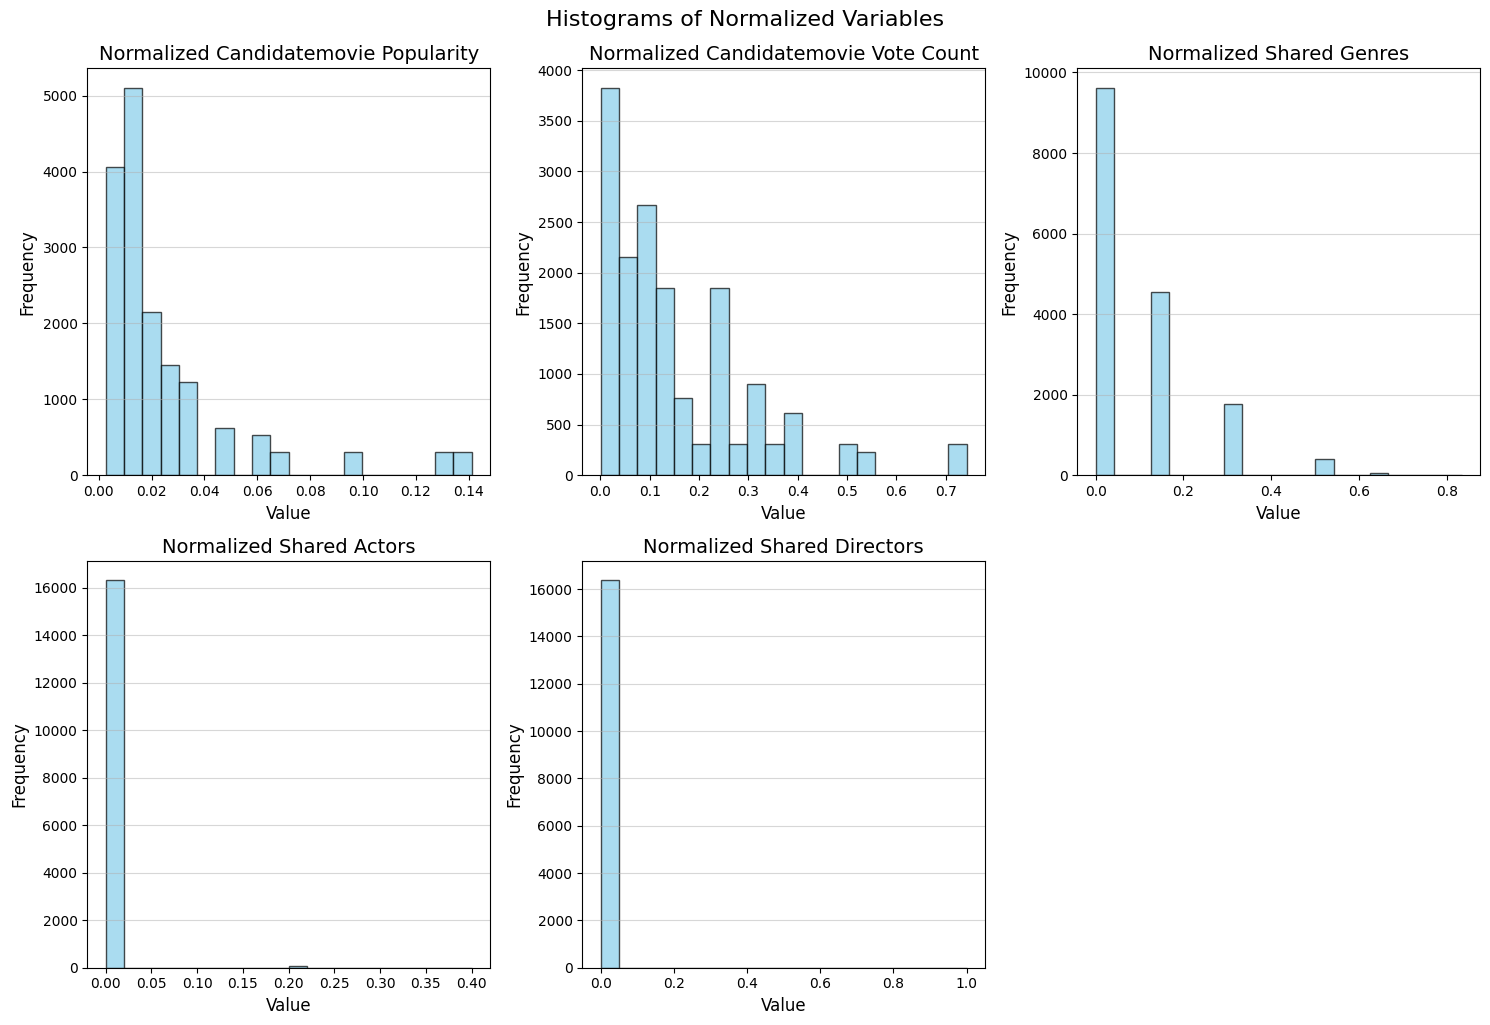

In [12]:
# Convert PySpark DataFrame to Pandas for visualization
normalized_columns = [f"normalized_{var}" for var in variables_to_normalize]
normalized_df = merged_df.select(normalized_columns).toPandas()

# Plot histograms for each normalized variable
plt.figure(figsize=(15, 10))

for i, column in enumerate(normalized_columns, 1):
    plt.subplot(2, 3, i)
    plt.hist(normalized_df[column], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title(column.replace('_', ' ').title(), fontsize=14)
    plt.xlabel('Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', alpha=0.5)

plt.tight_layout()
plt.suptitle("Histograms of Normalized Variables", fontsize=16, y=1.02)
plt.show()

Creating